In [1]:
# imports
import cv2 as cv
import numpy as np
import os

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader
#from torchvision.tranforms import ToTensor

%matplotlib inline

In [2]:
#Testing


img = cv.imread('Pepperoni/Images/b1/b1p11.png', 0)

small = cv.resize(img, (50,70))
#smallblur = cv.blur(small, (5,5))


'''
cv.imshow('small', small)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)
'''


print(small)
norm = np.linalg.norm(small)
print(norm)
small = small/norm
print(small)


[[100 115 124 ...  56  33  16]
 [ 42  91  96 ...  34  29  14]
 [ 57  75  79 ...  10  13  19]
 ...
 [ 26  33  41 ...  28  29  17]
 [ 42  39  36 ...  35  41  55]
 [ 58  47  40 ...  30  78   9]]
1994.0368602410538
[[0.05014952 0.05767195 0.06218541 ... 0.02808373 0.01654934 0.00802392]
 [0.0210628  0.04563607 0.04814354 ... 0.01705084 0.01454336 0.00702093]
 [0.02858523 0.03761214 0.03961812 ... 0.00501495 0.00651944 0.00952841]
 ...
 [0.01303888 0.01654934 0.0205613  ... 0.01404187 0.01454336 0.00852542]
 [0.0210628  0.01955831 0.01805383 ... 0.01755233 0.0205613  0.02758224]
 [0.02908672 0.02357028 0.02005981 ... 0.01504486 0.03911663 0.00451346]]


In [3]:
## Getting Labels

def convert_to_single(x):
    x = round(int(x), -1)
    x = x/10 - 1
    return x

def get_label_batch(dir, num_labels):
    for i in range(1, num_labels+1):
        filepath = dir + str(i) + '.txt'
        with open(filepath, 'r') as file:
            label = file.read()
            #label = convert_to_single(label) # CONVERT 1-10
            labels.append(int(label))

def get_labels():
    get_label_batch('Pepperoni/Labels/b1/b1p', 18)
    get_label_batch('Pepperoni/Labels/b2/b2p', 21)
    get_label_batch('Pepperoni/Labels/b3/b3p', 9)
    get_label_batch('Pepperoni/Labels/b4/b4p', 25)
    get_label_batch('Pepperoni/Labels/b5/b5p', 8)
    get_label_batch('Pepperoni/Labels/b6/b6p', 53)

In [5]:
# Getting Images

def preprocess(img):
    img = cv.blur(img, (20, 20))
    img = cv.resize(img, (50, 70))
    img = img.flatten()
    return img

def get_img_batch(dir, num_imgs):
    for i in range(1, num_imgs+1):
        filepath = dir + str(i) + '.png'
        img = cv.imread(filepath, 0)
        img = preprocess(img)
        imgs.append(img)

def get_imgs():
    get_img_batch('Pepperoni/Images/b1/b1p', 18)
    get_img_batch('Pepperoni/Images/b2/b2p', 21)
    get_img_batch('Pepperoni/Images/b3/b3p', 9)
    get_img_batch('Pepperoni/Images/b4/b4p', 25)
    get_img_batch('Pepperoni/Images/b5/b5p', 8)
    get_img_batch('Pepperoni/Images/b6/b6p', 53)

In [13]:
class Model(nn.Module):
    def __init__(self, in_features=3500, h1=64, h2=218, h3=256, h4=512, h5=1024, out_features=128):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features, h1)
        #self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(h1, h2)
        #self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(h2, h3)
        #self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(h3, h4)
        #self.dropout4 = nn.Dropout(0.2)
        self.fc5 = nn.Linear(h4, h5)
        #self.dropout5 = nn.Dropout(0.2)
        self.out = nn.Linear(h5, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        #x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        #x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        #x = self.dropout4(x)
        x = F.relu(self.fc5(x))
        #x = self.dropout5(x)
        x = self.out(x)

        return x

In [14]:
# GET LABELS
labels = []
get_labels()
np.shape(labels)
#np.array(sorted(labels))

(134,)

In [15]:
# GET IMAGES
imgs = []
get_imgs()
np.shape(imgs)

(134, 3500)

In [100]:
# GET TRAIN/TEST SPLIT
X = imgs
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)
np.shape(X_train)

torch.Size([127, 3500])

In [101]:
# CREATE MODEL (RUN MODEL CELL TO UPDATE)

model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.1)

In [106]:
# TRAINING
epochs = 1000
losses = []
for i in range(epochs):
    y_pred = model.forward(X_train) #train
    loss = criterion(y_pred, y_train) #track loss
    losses.append(loss.detach().numpy())#converting idk

    #printing
    if i % 100 == 0:
        print(f'Epoch: {i} Loss: {loss}')

    
    #back propogation ----fine tuning weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 Loss: 0.13641084730625153
Epoch: 100 Loss: 0.12898381054401398
Epoch: 200 Loss: 0.12242099642753601
Epoch: 300 Loss: 0.1177564412355423
Epoch: 400 Loss: 0.11413881182670593
Epoch: 500 Loss: 0.11095564067363739
Epoch: 600 Loss: 0.10786538571119308
Epoch: 700 Loss: 0.10512221604585648
Epoch: 800 Loss: 0.10252568125724792
Epoch: 900 Loss: 0.10015112161636353


Text(0, 0.5, 'Loss')

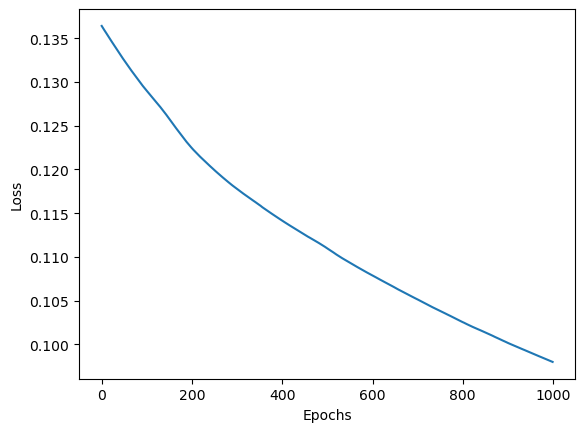

In [107]:
plt.plot(range(epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [108]:
# results of training
num_right = 0
with torch.no_grad():
    for i, data in enumerate(X_train):
        y_val = model.forward(data)
        if y_val.argmax() == y_train[i]:
            num_right += 1
print(f'Train Accuracy: {num_right / len(X_train)}')

Train Accuracy: 1.0


In [109]:
#testing
acc = 0
with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        acc = acc + (abs(y_val.argmax() - y_test[i]))
        print(f'pred: {y_val.argmax()} \t actual: {y_test[i]}')
print(f'Test Avg Diff: {acc/len(X_test)}')

pred: 82 	 actual: 87
pred: 78 	 actual: 72
pred: 74 	 actual: 75
pred: 82 	 actual: 84
pred: 117 	 actual: 113
pred: 85 	 actual: 70
pred: 111 	 actual: 112
Test Avg Diff: 4.857142925262451
